# Basic BoW model 

#### Basic imports

In [1]:
import re
import matplotlib.pyplot as plt
from data import get_data
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def cleanup(x):
    # removes punctuation
    x = re.sub(r'[.,"!#/]+', ' ', x, flags=re.MULTILINE)
    # removs \\n
    x = re.sub(r'\\n', ' ', x, flags=re.MULTILINE)
    # removes retweets (e.g. @FER)
    x = re.sub(r'@\w+', '', x, flags=re.MULTILINE)

    return x

## EI-oc (Emotion intensity ordinal classification)

In [3]:
emotions = ['anger', 'fear', 'joy', 'sadness']


def ei_oc_data(emotion):
    X_train, y_train = get_data('data/EI-oc-En-{}-train.txt'.format(emotion))
    X_test, y_test = get_data('data/2018-EI-oc-En-{}-dev.txt'.format(emotion))

    X_train_clean = [cleanup(x) for x in X_train]
    X_test_clean = [cleanup(x) for x in X_test]
    return X_train_clean, y_train, X_test_clean, y_test


def ei_reg_data(emotion):
    X_train, y_train = get_data('data/EI-reg-En-{}-train.txt'.format(emotion))
    X_test, y_test = get_data('data/2018-EI-reg-En-{}-dev.txt'.format(emotion))

    X_train_clean = [cleanup(x) for x in X_train]
    X_test_clean = [cleanup(x) for x in X_test]
    return X_train_clean, y_train, X_test_clean, y_test

In [4]:
# char ngrams work better than tfidf
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english', analyzer='char')
#vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=500)
normalizer = Normalizer()
clsf = OneVsRestClassifier(LinearSVC(random_state=42))

estimators = [('vectorize', vectorizer), ('normalize', normalizer), ('clsf', clsf)]

In [5]:
for e in emotions:
    X_train, y_train, X_test, y_test = ei_oc_data(e)
    pipe = Pipeline(memory=None, steps=estimators).fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print("\t{}:\n{}".format(e.upper(), classification_report(y_test, y_pred)))
    print('-'*80)
    
uniq = np.unique(y_test)

# random acc nam je bio visok jer je y_rand bio € [0, 1, 2]
y_rand = np.random.randint(uniq[0], uniq[-1] + 1, y_test.shape[0])
print('\t{}:\n{}'.format("RANDOM", classification_report(y_test, y_rand)))

	ANGER:
             precision    recall  f1-score   support

          0       0.62      0.52      0.56       186
          1       0.12      0.07      0.09        54
          2       0.31      0.41      0.36        97
          3       0.33      0.47      0.39        51

avg / total       0.44      0.42      0.42       388

--------------------------------------------------------------------------------
	FEAR:
             precision    recall  f1-score   support

          0       0.67      0.99      0.80       251
          1       0.29      0.04      0.06        57
          2       0.00      0.00      0.00        57
          3       0.25      0.08      0.12        24

avg / total       0.49      0.65      0.53       389

--------------------------------------------------------------------------------
	JOY:
             precision    recall  f1-score   support

          0       0.25      0.67      0.36        55
          1       0.32      0.09      0.15        95
          2    

In [6]:
from sklearn.preprocessing import OneHotEncoder

#from keras.utils.np_utils import to_categorical

X_train, y_train = get_data('data/2018-EI-oc-En-anger-dev.txt')

#print(to_categorical(y_train))
enc = OneHotEncoder()
#y_train = enc.fit_transform(y_train.reshape(-1, 1))
#print(y_train)


#y_rand = np.array([np.round(np.random.uniform(0, 1, y_test.shape[1])) for _ in range(y_test.shape[0])])
#print(accuracy_score(y_test, y_rand))

## EI-reg (Emotional intensity regression)

In [7]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error

In [8]:
y_rand = np.array([np.random.uniform(0, 1, y_test.shape[0])])

# char ngrams work better than tfidf
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english', analyzer='char', max_features=500)
#vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=500)
normalizer = Normalizer()
reg = LinearRegression()

estimators = [('vectorize', vectorizer), ('normalize', normalizer), ('clsf', reg)]

In [9]:
def train_EI_for_all_emotions():
    pipes = {}
    for e in emotions:
        X_train, y_train, X_test, y_test = ei_reg_data(e)
        pipe = Pipeline(memory=None, steps=estimators).fit(X_train, y_train)
        pipe.fit(X_train, y_train)
        pipes[e] = pipe

    return pipes

pipes = train_EI_for_all_emotions()

	anger: (0.0590493605636915, 0.2458870052330966)
	fear: (0.1017416104411603, 0.044919545403439114)
	joy: (-0.16505986452062407, 0.0048311292198190345)
	sadness: (0.3006502320655385, 9.744757370364217e-10)
	Pearson R for random: (-0.14475923934800655, 0.0038468827732607166)


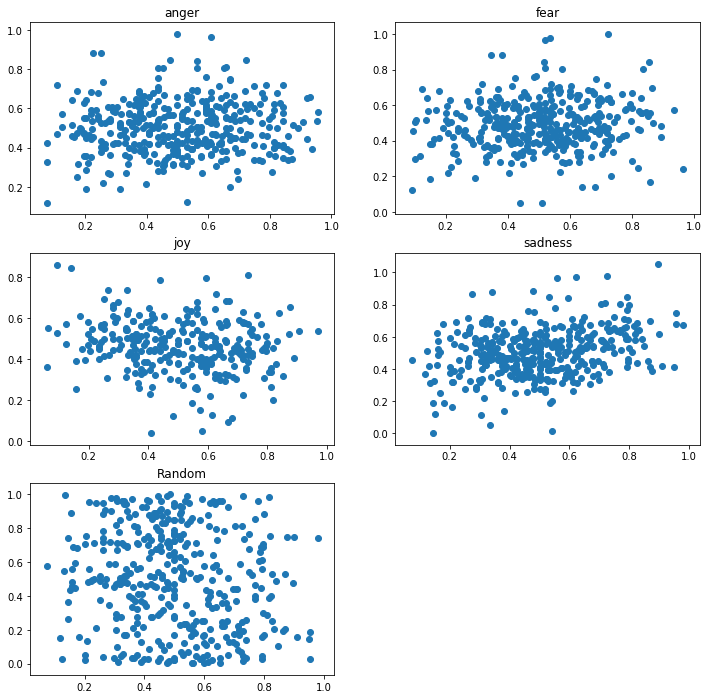

In [10]:
cnt = 1
plt.figure(1, figsize(12,12))
for e in emotions:
    X_train, y_train, X_test, y_test = ei_reg_data(e)
    pred = pipes[e].predict(X_test)
    print('\t{}: {}'.format(e, pearsonr(y_test, pred)))
    subplot(3, 2, cnt)
    plt.title(e)
    plt.scatter(y_test, pred)
    
    cnt += 1
    
import time; time.sleep(1)
y_rand = np.random.uniform(size=y_test.shape[0])
random_pearson = pearsonr(y_test, y_rand)
print('\tPearson R for random:', pearsonr(y_test, y_rand))
subplot(3, 2, cnt)
plt.title('Random')
plt.scatter(y_test, y_rand)
    
plt.show()